In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10     # 分类类别数

# Training
BATCH_SIZE = 128   #每次训练的数据样本数
NUM_EPOCHS = 45    # 遍历整个数据集的次数
EVAL_INTERVAL=1    # 多少周期/批次后对模型进行评估
SAVE_DIR = './log' #保存模型权重和日志的目录

# Optimizer
# 学习率决定了参数更新的幅度。太大的学习率可能导致模型无法收敛，而太小的学习率可能导致训练速度缓慢
LEARNING_RATE1 = 1e-1
# 动量可以帮助加速梯度向量在正确方向上的收敛，并且可以摆脱局部极值。
MOMENTUM = 0.9
STEP=5    #多少周期后调整（通常是减少）学习率
GAMMA=0.5  # 学习率衰减的系数

In [3]:
# device 变量会被设置为可用的GPU（如果有的话），否则它会被设置为CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# cifar10 transform
#1.数据增强与预处理
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #对图像进行随机裁剪到32x32大小，但在裁剪之前，首先对图像进行填充4个像素
    transforms.RandomHorizontalFlip(),     #随机地以一半的概率对图像进行水平翻转
    transforms.ToTensor(),                 #将图像从PIL Image格式转换为PyTorch的张量格式
    #对图像进行标准化。这里的两个元组分别表示三个通道（RGB）的平均值和标准偏差。
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#2.测试数据的预处理步骤，没有数据增强
transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# 3.加载数据集
train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
# 4.创建数据加载器
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2) 
# 用于在训练或测试时按批次加载数据，在训练时随机打乱数据。
#2个子进程来加载数据，这可以加速数据加载

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 输入是形状为(batch_size, 3, 32, 32)的张量，3: 这代表图像的颜色通道数；32: 这是图像的高度，表示图像中的像素行数；32: 这是图像的宽度，表示图像中的像素列数。
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # First block of convolutions
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            ##使用3x3的卷积核从3个输入通道到32个输出通道。由于设置了填充（padding），所以输出大小与输入大小相同，即(batch_size, 32, 32, 32)
            nn.BatchNorm2d(32),     #批归一化，用于加速训练和提高模型的稳定性
            nn.ReLU(inplace=True),  #修正线性单元激活函数
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
            #最大池化层，将特征图的大小降为原来的一半，即(batch_size, 64, 16, 16)
        )
        
        # Second block of convolutions (batch_size, 128, 8, 8)
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Third block of convolutions  (batch_size, 256, 4, 4)
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            #将形状为(batch_size, 256, 4, 4)的张量变形为(batch_size, 256*4*4)，然后传递到有512个单元的全连接层
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            #Dropout层，用于防止过拟合
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  #输出层有10个单元，对应于10个分类类别
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)   # 模型的输出是一个形状为(batch_size, 10)的张量
        return x


In [6]:
model = ConvNet()  
model.to(device)

ConvNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE1, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [8]:
import os.path as osp

def train_and_test_model(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss, training_acc, testing_loss, testing_acc):
    epoch_loss=0
    epoch_acc = 0
    confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
    for epoch in range(NUM_EPOCHS):
        model.train()  # 设置模型为训练模式
        torch.cuda.empty_cache()  # 清空GPU缓存

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # train model
            # 函数train_batch负责执行前向传播并计算损失
            # 模型的输出被解释为分类的概率分数
            # 使用torch.max来获取预测的类别
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            
            # 损失检查：确保在训练过程中损失没有变成NaN
            if np.isnan(loss.data.item()):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            
            # 反向传播与优化
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # 计算每个epoch的平均损失和准确率
        epoch_loss = running_cls_loss / len(train_dataloader.dataset)
        epoch_acc = running_cls_corrects.double() / len(train_dataloader.dataset)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())
        
        # 学习率调度
        scheduler.step()
        
        # 检查是否达到了模型评估的时间点。
        # 在每过EVAL_INTERVAL个周期后评估模型，或者在最后一个周期结束时评估模型
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()  #将模型设置为评估模式

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
                # 在训练和测试循环中
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1


            val_loss /= len(test_dataloader.dataset)
            val_acc = val_corrects.double() / len(test_dataloader.dataset)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())
            
            #保存模型的检查点
            if (epoch +1) == NUM_EPOCHS:
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)
                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                }
                torch.save(state, osp.join(SAVE_DIR, f'checkpoint_{epoch+1}.pth'))
                # 为每个类别计算精确度、召回率和F1分数
                precision = torch.diag(confusion_matrix) / confusion_matrix.sum(0)
                recall = torch.diag(confusion_matrix) / confusion_matrix.sum(1)
                F1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # 1e-6 is added to avoid division by zero

                # 打印每个类别的精确度、召回率和F1分数
                for i in range(10):
                    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {F1[i]:.4f}')

        confusion_matrix.fill_(0)
    return training_loss, training_acc, testing_loss, testing_acc


### MAE loss function

In [11]:
model = ConvNet() # or whatever way you initialize your model
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE1, momentum=MOMENTUM) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.L1Loss()
def train_batch(model, data, target):
    optimizer.zero_grad()
    outputs = model(data)
    target_onehot = F.one_hot(target, NUM_CLASS).float()  # Convert target to one-hot encoding
    loss = criterion(outputs, target_onehot)
    return outputs, loss

def test_batch(model, data, target):
    with torch.no_grad():
        outputs = model(data)
        target_onehot = F.one_hot(target, NUM_CLASS).float()  # Convert target to one-hot encoding
        loss = criterion(outputs, target_onehot)
    return outputs, loss


training_loss1 = []
training_acc1 = []
testing_loss1 = []
testing_acc1 = []

import os.path as osp

def train_and_test_modelForL1(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss, training_acc, testing_loss, testing_acc):
    epoch_loss=0
    epoch_acc = 0
    confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
    for epoch in range(NUM_EPOCHS):
        model.train()  # 设置模型为训练模式
        torch.cuda.empty_cache()  # 清空GPU缓存

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # train model
            # 函数train_batch负责执行前向传播并计算损失
            # 模型的输出被解释为分类的概率分数
            # 使用torch.max来获取预测的类别
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            loss = criterion(F.softmax(outputs,dim=1),F.one_hot(target,num_classes=10))
            
            
            # 损失检查：确保在训练过程中损失没有变成NaN
            if np.isnan(loss.data.item()):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            
            # 反向传播与优化
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # 计算每个epoch的平均损失和准确率
        epoch_loss = running_cls_loss / len(train_dataloader.dataset)
        epoch_acc = running_cls_corrects.double() / len(train_dataloader.dataset)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())
        
        # 学习率调度
        scheduler.step()
        
        # 检查是否达到了模型评估的时间点。
        # 在每过EVAL_INTERVAL个周期后评估模型，或者在最后一个周期结束时评估模型
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()  #将模型设置为评估模式

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)
                loss = criterion(F.softmax(outputs,dim=1),F.one_hot(target,num_classes=10))

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
                # 在训练和测试循环中
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1


            val_loss /= len(test_dataloader.dataset)
            val_acc = val_corrects.double() / len(test_dataloader.dataset)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())
            
            #保存模型的检查点
            if (epoch +1) == NUM_EPOCHS:
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)
                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                }
                torch.save(state, osp.join(SAVE_DIR, f'checkpoint_{epoch+1}.pth'))
                # 为每个类别计算精确度、召回率和F1分数
                precision = torch.diag(confusion_matrix) / confusion_matrix.sum(0)
                recall = torch.diag(confusion_matrix) / confusion_matrix.sum(1)
                F1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # 1e-6 is added to avoid division by zero

                # 打印每个类别的精确度、召回率和F1分数
                for i in range(10):
                    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {F1[i]:.4f}')

        confusion_matrix.fill_(0)
    return training_loss, training_acc, testing_loss, testing_acc

train_and_test_modelForL1(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss1, training_acc1, testing_loss1, testing_acc1)

Epoch: 1/45 Train Loss: 0.0011 Acc: 0.2830
Begin test......
Test Loss: 0.0010 Acc: 0.3528
Epoch: 2/45 Train Loss: 0.0009 Acc: 0.4072
Begin test......
Test Loss: 0.0009 Acc: 0.4594
Epoch: 3/45 Train Loss: 0.0009 Acc: 0.4500
Begin test......
Test Loss: 0.0009 Acc: 0.4489
Epoch: 4/45 Train Loss: 0.0008 Acc: 0.4719
Begin test......
Test Loss: 0.0009 Acc: 0.4499
Epoch: 5/45 Train Loss: 0.0008 Acc: 0.4788
Begin test......
Test Loss: 0.0009 Acc: 0.4385
Epoch: 6/45 Train Loss: 0.0008 Acc: 0.5145
Begin test......
Test Loss: 0.0008 Acc: 0.5084
Epoch: 7/45 Train Loss: 0.0007 Acc: 0.5291
Begin test......
Test Loss: 0.0007 Acc: 0.5362
Epoch: 8/45 Train Loss: 0.0007 Acc: 0.5350
Begin test......
Test Loss: 0.0008 Acc: 0.5239
Epoch: 9/45 Train Loss: 0.0007 Acc: 0.5406
Begin test......
Test Loss: 0.0007 Acc: 0.5543
Epoch: 10/45 Train Loss: 0.0007 Acc: 0.5460
Begin test......
Test Loss: 0.0007 Acc: 0.5596
Epoch: 11/45 Train Loss: 0.0007 Acc: 0.5630
Begin test......
Test Loss: 0.0007 Acc: 0.5724
Epoch: 1

([0.0011324043321609496,
  0.0009302367600798607,
  0.0008629010364413261,
  0.0008274171878397465,
  0.0008155964805185795,
  0.0007601382292807102,
  0.0007380238075554371,
  0.0007279746318608522,
  0.0007192663999646903,
  0.0007111776109039783,
  0.0006842383594810962,
  0.0006727841383963823,
  0.0006684194611012936,
  0.0006595700995624066,
  0.0006549444426596165,
  0.0006428177583217621,
  0.0006344830524921417,
  0.0006328512398153543,
  0.0006289640790224075,
  0.0006287995568662882,
  0.0006206664782017469,
  0.0006179901060461998,
  0.0006135966213792562,
  0.0006121005342155695,
  0.0006079707499593496,
  0.0006025672829896211,
  0.0005797161354124546,
  0.0005471056438982487,
  0.0005380334030091762,
  0.0005315931626409292,
  0.000526430012062192,
  0.0005256093170493842,
  0.0005227718964964152,
  0.0005199697794020175,
  0.0005186597760021686,
  0.000516417431384325,
  0.0005161014971882105,
  0.0005169520170241594,
  0.0005123084746301174,
  0.0005144182129949331,
  

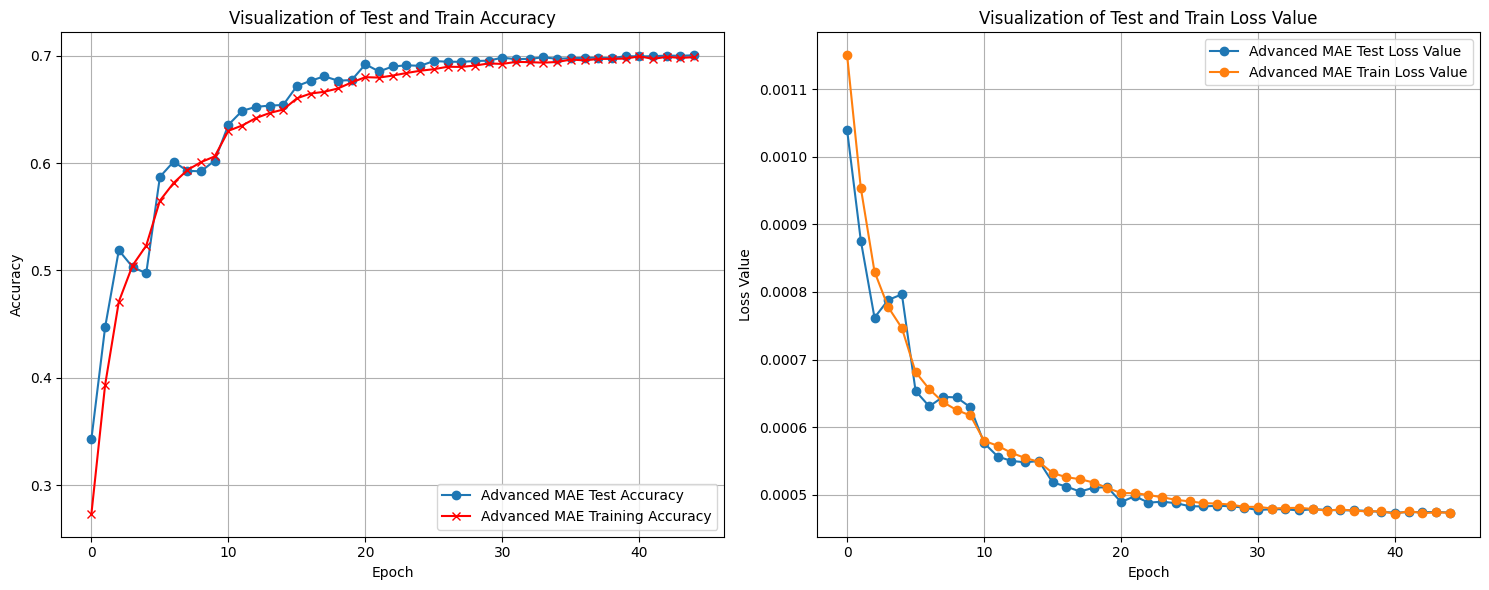

In [75]:
plt.figure(figsize=(15, 6))

# Subplot 1 for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(testing_acc1, '-o', label='Advanced MAE Test Accuracy')
plt.plot(training_acc1, '-x', label='Advanced MAE Training Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Visualization of Test and Train Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Subplot 2 for Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(testing_loss1, '-o', label='Advanced MAE Test Loss Value')
plt.plot(training_loss1, '-o', label='Advanced MAE Train Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Visualization of Test and Train Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plots
plt.show()


### CE loss function

In [9]:
#重置参数
model = ConvNet() # or whatever way you initialize your model
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE1, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.CrossEntropyLoss()
def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss
def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss
training_loss2_1 = []
training_acc2_1 = []
testing_loss2_1 = []
testing_acc2_1 = []
train_and_test_model(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss2_1, training_acc2_1, testing_loss2_1, testing_acc2_1)

Epoch: 1/45 Train Loss: 0.0158 Acc: 0.2176
Begin test......
Test Loss: 0.0142 Acc: 0.2594
Epoch: 2/45 Train Loss: 0.0138 Acc: 0.3036
Begin test......
Test Loss: 0.0118 Acc: 0.4389
Epoch: 3/45 Train Loss: 0.0110 Acc: 0.4885
Begin test......
Test Loss: 0.0099 Acc: 0.5715
Epoch: 4/45 Train Loss: 0.0088 Acc: 0.6130
Begin test......
Test Loss: 0.0084 Acc: 0.6321
Epoch: 5/45 Train Loss: 0.0074 Acc: 0.6826
Begin test......
Test Loss: 0.0072 Acc: 0.6926
Epoch: 6/45 Train Loss: 0.0058 Acc: 0.7539
Begin test......
Test Loss: 0.0056 Acc: 0.7536
Epoch: 7/45 Train Loss: 0.0053 Acc: 0.7787
Begin test......
Test Loss: 0.0048 Acc: 0.7923
Epoch: 8/45 Train Loss: 0.0049 Acc: 0.7945
Begin test......
Test Loss: 0.0052 Acc: 0.7715
Epoch: 9/45 Train Loss: 0.0044 Acc: 0.8128
Begin test......
Test Loss: 0.0044 Acc: 0.8136
Epoch: 10/45 Train Loss: 0.0042 Acc: 0.8258
Begin test......
Test Loss: 0.0046 Acc: 0.8085
Epoch: 11/45 Train Loss: 0.0035 Acc: 0.8522
Begin test......
Test Loss: 0.0037 Acc: 0.8425
Epoch: 1

([0.01577646052837372,
  0.013752227466106414,
  0.011018688917160034,
  0.008779582751989364,
  0.007431067047119141,
  0.005798098393678665,
  0.005253712817430496,
  0.004854180737137795,
  0.004432990026473999,
  0.0041591982454061505,
  0.003534218632876873,
  0.0033055838876962663,
  0.003126765214204788,
  0.002993589020073414,
  0.0029011165422201156,
  0.0024917900741100313,
  0.002351286783516407,
  0.00226825201690197,
  0.002140919731259346,
  0.002120884867757559,
  0.001933853417187929,
  0.0018536521361768245,
  0.0017844490233063699,
  0.0017537820336222649,
  0.0016839320458471776,
  0.0016166635401546954,
  0.0015440203662216664,
  0.0015252251388132572,
  0.0014645211907476188,
  0.001476181332692504,
  0.0014106472670286894,
  0.0013891271767020226,
  0.0013607736352831126,
  0.0013364309592545033,
  0.0013417653641104698,
  0.0013115253642201423,
  0.0012973904094845056,
  0.0012579347155243158,
  0.0012736767980456353,
  0.0012628742662817239,
  0.0012444113162159

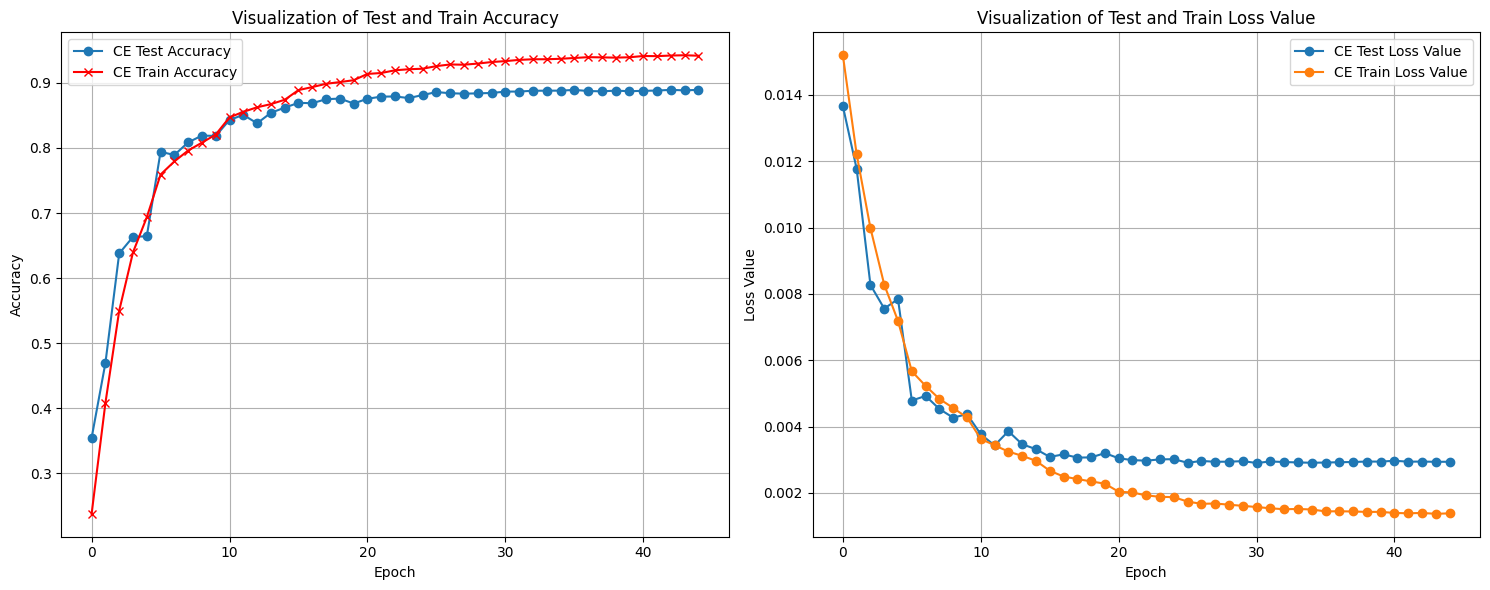

In [12]:
plt.figure(figsize=(15, 6))

# Subplot 1 for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(testing_acc2_1, '-o', label='CE Test Accuracy')
plt.plot(training_acc2_1, '-x', label='CE Train Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Visualization of Test and Train Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Subplot 2 for Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(testing_loss2_1, '-o', label='CE Test Loss Value')
plt.plot(training_loss2_1, '-o', label='CE Train Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Visualization of Test and Train Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plots
plt.show()


Focal loss (gamma=0.5)
---

In [15]:
import os.path as osp

def train_and_test_model(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss, training_acc, testing_loss, testing_acc):
    epoch_loss=0
    epoch_acc = 0
    confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
    for epoch in range(NUM_EPOCHS):
        model.train()  # 设置模型为训练模式
        torch.cuda.empty_cache()  # 清空GPU缓存

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            

            if np.isnan(loss.data.item()):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_dataloader.dataset)
        epoch_acc = running_cls_corrects.double() / len(train_dataloader.dataset)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())

        scheduler.step()

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
                # 在训练和测试循环中
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

            val_loss /= len(test_dataloader.dataset)
            val_acc = val_corrects.double() / len(test_dataloader.dataset)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())

            if (epoch +1) == NUM_EPOCHS:
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)
                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                }
                torch.save(state, osp.join(SAVE_DIR, f'checkpoint_{epoch+1}.pth'))
                # 为每个类别计算精确度、召回率和F1分数
                precision = torch.diag(confusion_matrix) / confusion_matrix.sum(0)
                recall = torch.diag(confusion_matrix) / confusion_matrix.sum(1)
                F1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # 1e-6 is added to avoid division by zero

                # 打印每个类别的精确度、召回率和F1分数
                for i in range(10):
                    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {F1[i]:.4f}')

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        confusion_matrix.fill_(0)
    return training_loss, training_acc, testing_loss, testing_acc


In [16]:
#重置参数
model = ConvNet() # or whatever way you initialize your model
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE1, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    
class FocalLoss1(nn.Module):
    def __init__(self, alpha=1., gamma=0.5):
        super(FocalLoss1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        eps = 1e-6  # Adding epsilon
        # Softmax across the classes
        probs = F.softmax(inputs, dim=1)
        
        # Gather only the probabilities associated with the ground truth labels
        target_probs = probs.gather(1, targets.unsqueeze(-1))
        
        # Compute the focal loss with added epsilon
        loss = -self.alpha * (1. - target_probs + eps)**self.gamma * (target_probs + eps).log()
        
        return loss.mean()


criterion = FocalLoss1()
def train_batch(model, data, target):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    return outputs, loss

def test_batch(model, data, target):
    with torch.no_grad():
        outputs = model(data)
        loss = criterion(outputs, target)
    return outputs, loss

training_loss3 = []
training_acc3 = []
testing_loss3 = []
testing_acc3 = []
train_and_test_model(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss3, training_acc3, testing_loss3, testing_acc3)

Epoch: 1/45 Train Loss: 0.0149 Acc: 0.2000
Begin test......
Test Loss: 0.0128 Acc: 0.2755
Epoch: 2/45 Train Loss: 0.0120 Acc: 0.3378
Begin test......
Test Loss: 0.0095 Acc: 0.4805
Epoch: 3/45 Train Loss: 0.0095 Acc: 0.5001
Begin test......
Test Loss: 0.0077 Acc: 0.5992
Epoch: 4/45 Train Loss: 0.0076 Acc: 0.6095
Begin test......
Test Loss: 0.0080 Acc: 0.6048
Epoch: 5/45 Train Loss: 0.0065 Acc: 0.6715
Begin test......
Test Loss: 0.0059 Acc: 0.7006
Epoch: 6/45 Train Loss: 0.0051 Acc: 0.7423
Begin test......
Test Loss: 0.0043 Acc: 0.7794
Epoch: 7/45 Train Loss: 0.0045 Acc: 0.7688
Begin test......
Test Loss: 0.0045 Acc: 0.7606
Epoch: 8/45 Train Loss: 0.0042 Acc: 0.7886
Begin test......
Test Loss: 0.0040 Acc: 0.7835
Epoch: 9/45 Train Loss: 0.0039 Acc: 0.8034
Begin test......
Test Loss: 0.0037 Acc: 0.8008
Epoch: 10/45 Train Loss: 0.0036 Acc: 0.8191
Begin test......
Test Loss: 0.0034 Acc: 0.8233
Epoch: 11/45 Train Loss: 0.0030 Acc: 0.8452
Begin test......
Test Loss: 0.0030 Acc: 0.8426
Epoch: 1

([0.014871708042621612,
  0.011992948980331422,
  0.009481644648313522,
  0.007629471195936203,
  0.006476868498325348,
  0.005059720288515091,
  0.004546060604453087,
  0.004177618446946144,
  0.003892975343465805,
  0.0035682916402816774,
  0.003002692856490612,
  0.0027976646465063095,
  0.00266861064016819,
  0.0025589183968305587,
  0.002406868430376053,
  0.0021165040144324305,
  0.0020257537898421287,
  0.0019518585881590843,
  0.0018611933678388596,
  0.0017979421432316304,
  0.0016488521300256252,
  0.0015863432654738426,
  0.0015155465511977673,
  0.0014896497333049775,
  0.0014599879397451877,
  0.001373364666700363,
  0.0013218873735517263,
  0.0013132822708785533,
  0.001298569301366806,
  0.0012576367262005807,
  0.0011963812398910522,
  0.0011793717924505473,
  0.0011753888765722513,
  0.0011656725991517306,
  0.0011444532291591167,
  0.0011211979172378779,
  0.0011014068043231965,
  0.0011231429859995842,
  0.001112738907635212,
  0.0011032910512387753,
  0.001093803258

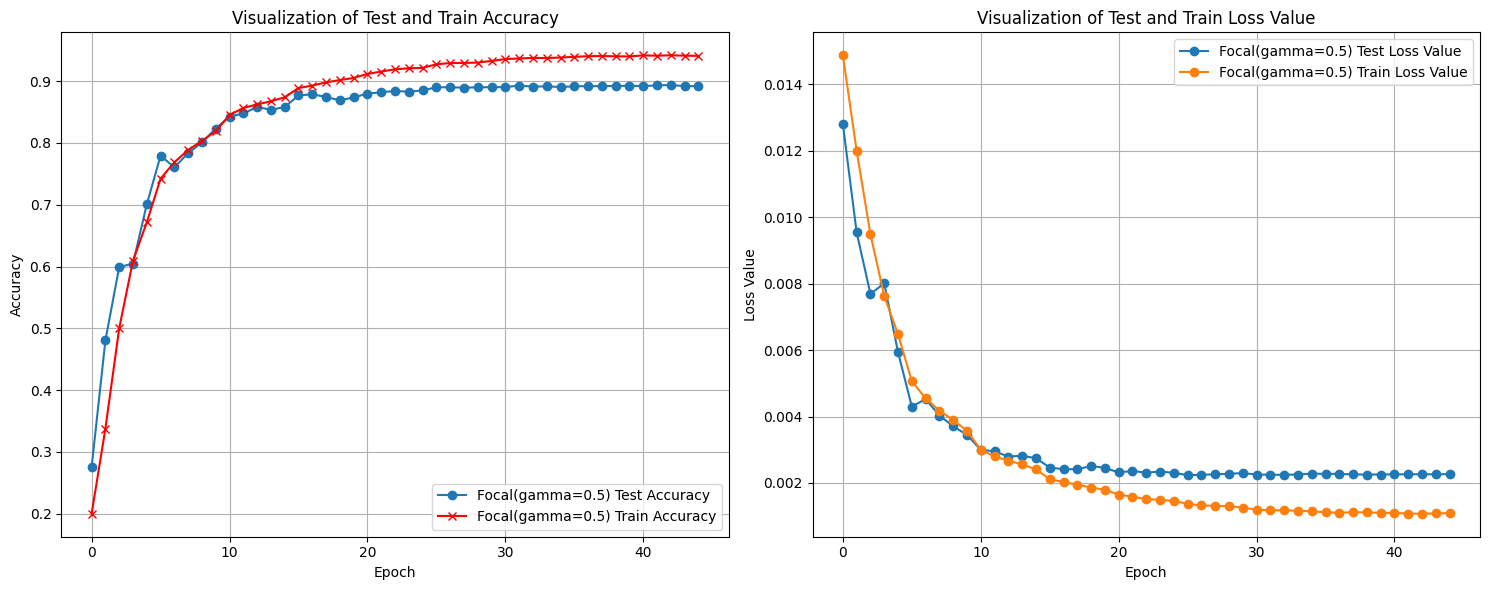

In [17]:
plt.figure(figsize=(15, 6))

# Subplot 1 for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(testing_acc3, '-o', label='Focal(gamma=0.5) Test Accuracy')
plt.plot(training_acc3, '-x', label='Focal(gamma=0.5) Train Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Visualization of Test and Train Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Subplot 2 for Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(testing_loss3, '-o', label='Focal(gamma=0.5) Test Loss Value')
plt.plot(training_loss3, '-o', label='Focal(gamma=0.5) Train Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Visualization of Test and Train Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plots
plt.show()


Focal loss (gamma=2)
---

In [18]:
#重置参数
model = ConvNet() # or whatever way you initialize your model
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE1, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    
class FocalLoss1(nn.Module):
    def __init__(self, alpha=1., gamma=2):
        super(FocalLoss1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        eps = 1e-6  # Adding epsilon
        # Softmax across the classes
        probs = F.softmax(inputs, dim=1)
        
        # Gather only the probabilities associated with the ground truth labels
        target_probs = probs.gather(1, targets.unsqueeze(-1))
        
        # Compute the focal loss with added epsilon
        loss = -self.alpha * (1. - target_probs + eps)**self.gamma * (target_probs + eps).log()
        
        return loss.mean()


criterion = FocalLoss1()
def train_batch(model, data, target):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    return outputs, loss

def test_batch(model, data, target):
    with torch.no_grad():
        outputs = model(data)
        loss = criterion(outputs, target)
    return outputs, loss

training_loss4 = []
training_acc4 = []
testing_loss4 = []
testing_acc4 = []
train_and_test_model(model, train_dataloader, test_dataloader, optimizer, scheduler, device, NUM_EPOCHS, EVAL_INTERVAL, SAVE_DIR, training_loss4, training_acc4, testing_loss4, testing_acc4)

Epoch: 1/45 Train Loss: 0.0116 Acc: 0.2277
Begin test......
Test Loss: 0.0094 Acc: 0.2974
Epoch: 2/45 Train Loss: 0.0087 Acc: 0.3629
Begin test......
Test Loss: 0.0071 Acc: 0.4420
Epoch: 3/45 Train Loss: 0.0068 Acc: 0.4879
Begin test......
Test Loss: 0.0055 Acc: 0.5801
Epoch: 4/45 Train Loss: 0.0056 Acc: 0.5803
Begin test......
Test Loss: 0.0048 Acc: 0.6318
Epoch: 5/45 Train Loss: 0.0047 Acc: 0.6401
Begin test......
Test Loss: 0.0040 Acc: 0.6895
Epoch: 6/45 Train Loss: 0.0037 Acc: 0.7097
Begin test......
Test Loss: 0.0033 Acc: 0.7285
Epoch: 7/45 Train Loss: 0.0033 Acc: 0.7386
Begin test......
Test Loss: 0.0031 Acc: 0.7590
Epoch: 8/45 Train Loss: 0.0031 Acc: 0.7552
Begin test......
Test Loss: 0.0027 Acc: 0.7821
Epoch: 9/45 Train Loss: 0.0028 Acc: 0.7721
Begin test......
Test Loss: 0.0029 Acc: 0.7759
Epoch: 10/45 Train Loss: 0.0027 Acc: 0.7844
Begin test......
Test Loss: 0.0025 Acc: 0.7859
Epoch: 11/45 Train Loss: 0.0022 Acc: 0.8111
Begin test......
Test Loss: 0.0022 Acc: 0.8077
Epoch: 1

([0.011593825325965881,
  0.008693263292312622,
  0.006788103773593903,
  0.005568874616622925,
  0.004736217902898789,
  0.003666817307472229,
  0.0032690083134174347,
  0.003058790424764156,
  0.002819972460269928,
  0.002654530017077923,
  0.0021950125256180765,
  0.002058067065477371,
  0.001979384620189667,
  0.0018719065114855766,
  0.0018130609254539012,
  0.0015799625106155872,
  0.0015014505149424076,
  0.001450560758560896,
  0.0014012434469163418,
  0.0013730398406088353,
  0.0012404108452796936,
  0.0012115524271130561,
  0.001167498882561922,
  0.0011563627280294895,
  0.0011196732141077518,
  0.0010687262236326932,
  0.0010331713190674782,
  0.0010270132691413165,
  0.0010174539313465357,
  0.0010124755593389273,
  0.0009738017816841603,
  0.0009649742540717125,
  0.000931758201867342,
  0.0009360385889559984,
  0.0009351612379401922,
  0.0009244099432975054,
  0.0009109833934903145,
  0.0009026807991415262,
  0.0008984543405473232,
  0.0008932547616958618,
  0.0008773311

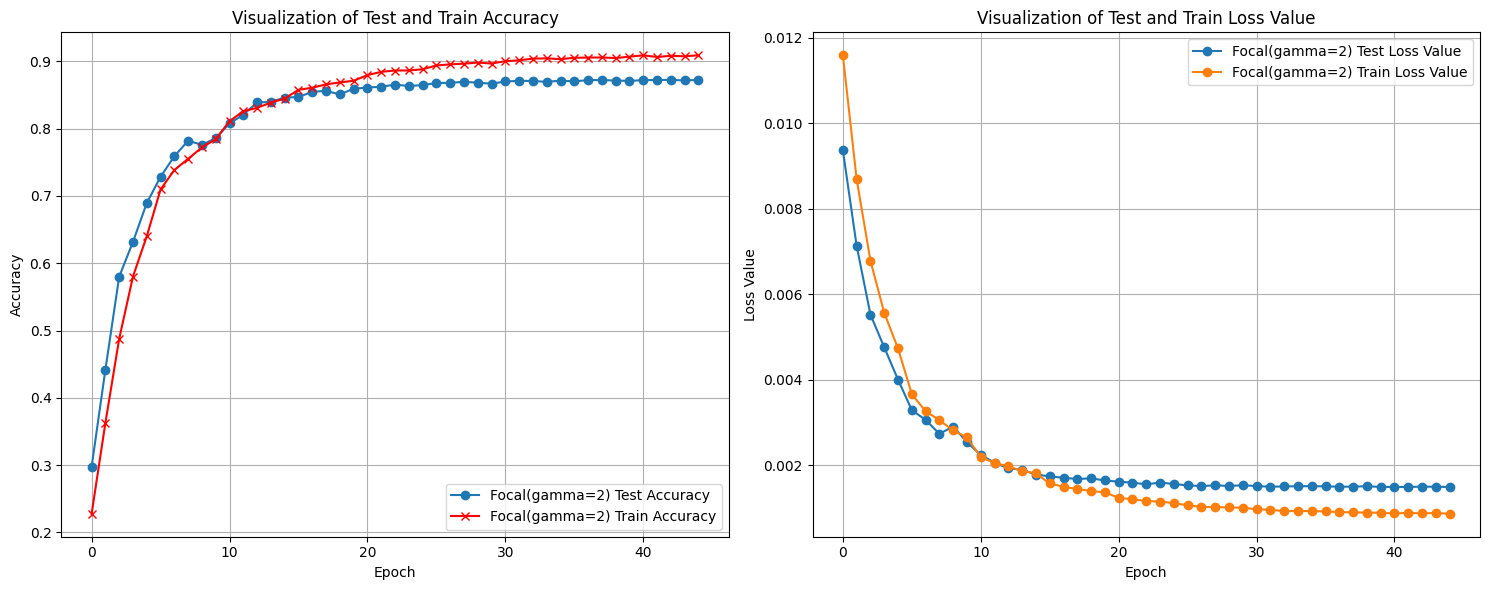

In [19]:
plt.figure(figsize=(15, 6))

# Subplot 1 for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(testing_acc4, '-o', label='Focal(gamma=2) Test Accuracy')
plt.plot(training_acc4, '-x', label='Focal(gamma=2) Train Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Visualization of Test and Train Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Subplot 2 for Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(testing_loss4, '-o', label='Focal(gamma=2) Test Loss Value')
plt.plot(training_loss4, '-o', label='Focal(gamma=2) Train Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Visualization of Test and Train Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plots
plt.show()


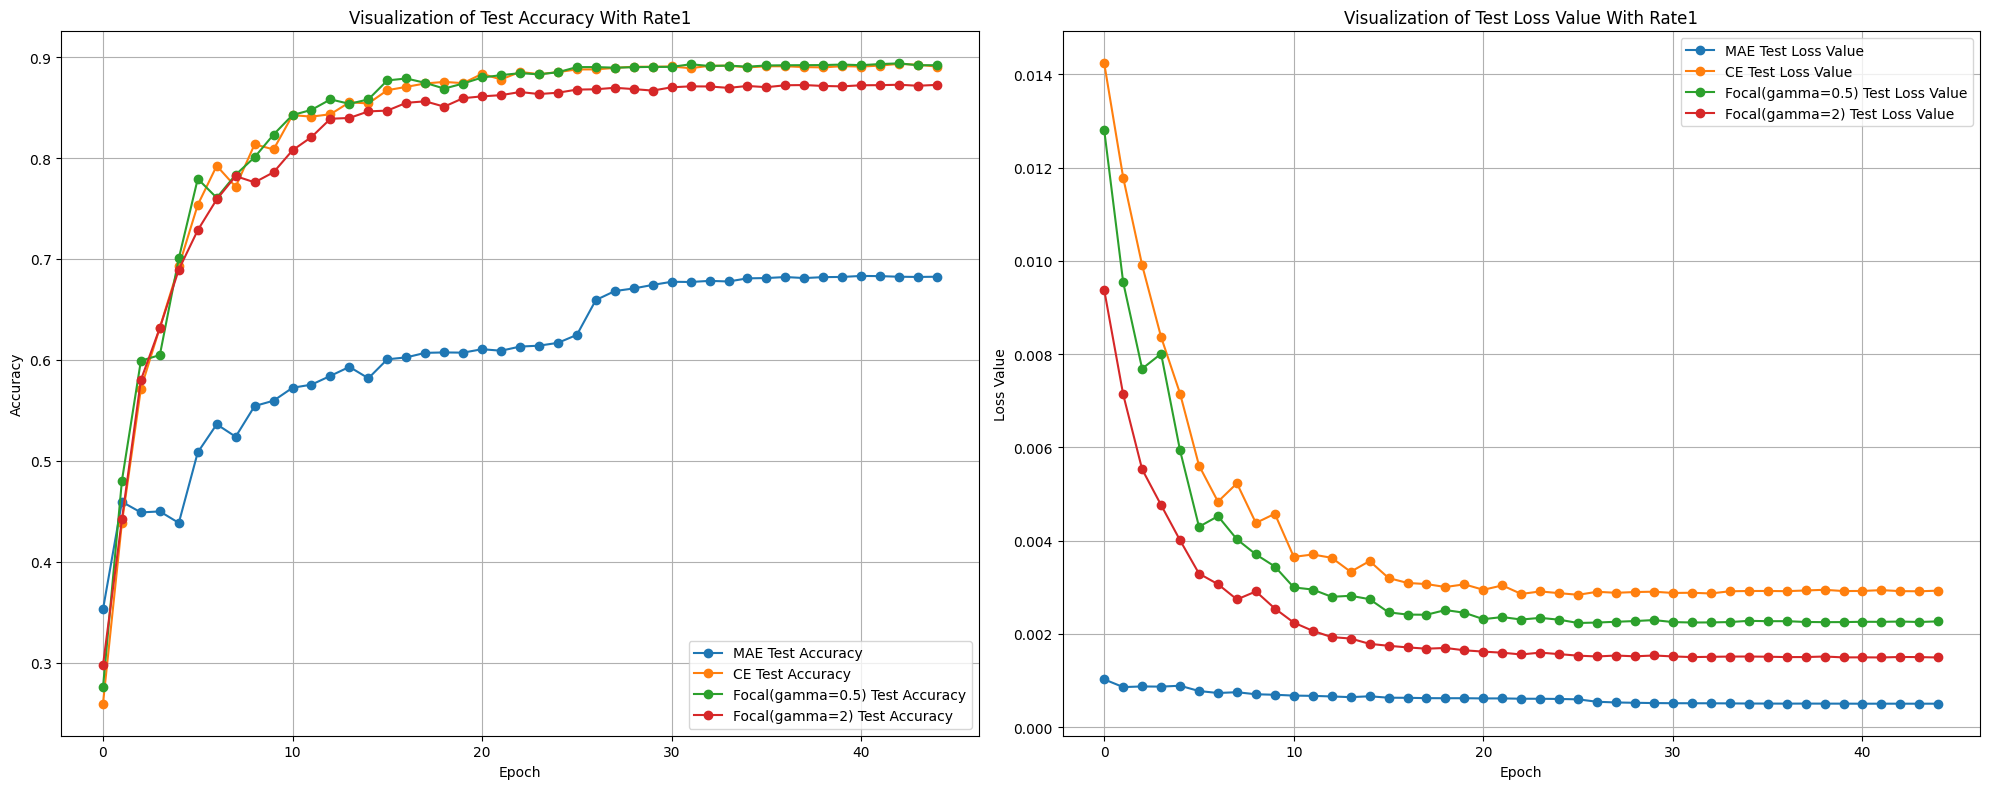

In [20]:
plt.figure(figsize=(20, 8))

# Subplot 1 for Accuracy
plt.subplot(1, 2, 1)  # 3 row, 2 columns, first plot
plt.plot(testing_acc1, '-o', label='MAE Test Accuracy')
plt.plot(testing_acc2_1, '-o', label='CE Test Accuracy')
plt.plot(testing_acc3, '-o', label='Focal(gamma=0.5) Test Accuracy')
plt.plot(testing_acc4, '-o', label='Focal(gamma=2) Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Visualization of Test Accuracy With Rate1')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Subplot 2 for Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(testing_loss1, '-o', label='MAE Test Loss Value')
plt.plot(testing_loss2_1, '-o', label='CE Test Loss Value')
plt.plot(testing_loss3, '-o', label='Focal(gamma=0.5) Test Loss Value')
plt.plot(testing_loss4, '-o', label='Focal(gamma=2) Test Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Visualization of Test Loss Value With Rate1')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
